## Exercise 1:  Wide and Deep Networks

- Try changing your assumptions about which features should be considered by the "non-linear" (deep) part of the network.  Can you get any improvements?
- Try using a different activation function in your wide and deep network. Do you get any improvements here?

In [2]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

2024-04-04 14:44:56.775784: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 14:44:56.780224: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 14:44:56.821848: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 14:44:58.206823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)
# Reserve an item for prediction
X_new = X_test[:3]

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

# Note the offsets are used here to split up the features according to our input layer
X_train_wide, X_train_deep = X_train[:, :4], X_train[:, 4:] 
X_valid_wide, X_valid_deep = X_valid[:, :4], X_valid[:, 4:] 
X_test_wide, X_test_deep = X_test[:, :4], X_test[:, 4:] 
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

input_wide = tf.keras.layers.Input(shape=[4])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[4])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])

In [30]:
# Remember to adapt the normalization layers!!!
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - dense_2_RootMeanSquaredError: 1.4823 - dense_3_RootMeanSquaredError: 1.7678 - loss: 2.3835 - val_dense_2_RootMeanSquaredError: 1.3813 - val_dense_3_RootMeanSquaredError: 2.8399 - val_loss: 2.5227
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_2_RootMeanSquaredError: 0.8132 - dense_3_RootMeanSquaredError: 1.0217 - loss: 0.7003 - val_dense_2_RootMeanSquaredError: 0.6941 - val_dense_3_RootMeanSquaredError: 2.1200 - val_loss: 0.8827
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_2_RootMeanSquaredError: 0.7259 - dense_3_RootMeanSquaredError: 0.9546 - loss: 0.5657 - val_dense_2_RootMeanSquaredError: 0.8231 - val_dense_3_RootMeanSquaredError: 1.0966 - val_loss: 0.7297
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_2_RootMeanSquaredError: 0.6834 - dense_3_RootMeanSquaredError: 0.9341 - loss: 0.5079 - val_dense_2_RootMeanSquaredError: 0.6309 - val_dense_3_RootMeanSquaredError: 1.1271 - val_loss: 0.4852


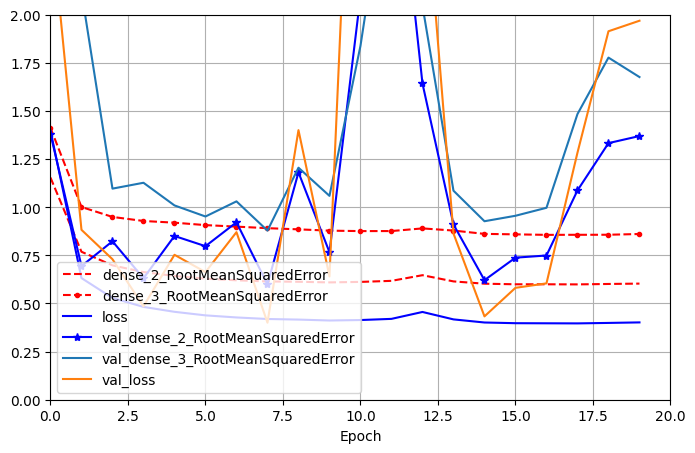

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 20], ylim=[0, 2], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()

In [32]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError","RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - RootMeanSquaredError: 1.6595 - RootMeanSquaredError_1: 1.7137 - loss: 2.8717 - val_RootMeanSquaredError: 1.1095 - val_RootMeanSquaredError_1: 1.4125 - val_loss: 1.3071
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.8676 - RootMeanSquaredError_1: 1.0238 - loss: 0.7834 - val_RootMeanSquaredError: 0.7366 - val_RootMeanSquaredError_1: 0.9555 - val_loss: 0.5795
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.7190 - RootMeanSquaredError_1: 0.9421 - loss: 0.5543 - val_RootMeanSquaredError: 0.6541 - val_RootMeanSquaredError_1: 0.9100 - val_loss: 0.4678
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6636 - RootMeanSquaredError_1: 0.9155 - loss: 0.4803 - val_RootMeanSquaredError: 0.6212 - val_RootMeanSquaredError_1: 0.8974 - val_loss: 0.4277
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6414 - RootMeanSquaredError_1: 0.9

ValueError: not enough values to unpack (expected 5, got 3)

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

# Doubled the learning
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError","RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)

In [39]:
from pathlib import Path 
from time import strftime
def get_run_logdir(root_logdir="./logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")


get_run_logdir()

PosixPath('logs/run_2024_04_04_15_11_11')

In [40]:
test_dir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(test_dir, profile_batch=(100, 200))
history=model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),callbacks=[tensorboard_cb])

Epoch 1/20


2024-04-04 15:11:15.270793: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-04-04 15:11:15.270843: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-04-04 15:11:15.271936: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


200/363 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 1.3701 - RootMeanSquaredError_1: 1.6200 - loss: 2.0200

2024-04-04 15:11:16.633495: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-04-04 15:11:16.633533: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-04-04 15:11:16.787404: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-04-04 15:11:16.798867: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-04-04 15:11:16.799818: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: logs/run_2024_04_04_15_11_15/plugins/profile/2024_04_04_15_11_16/codespaces-b89551.xplane.pb


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - RootMeanSquaredError: 1.2113 - RootMeanSquaredError_1: 1.4521 - loss: 1.6007 - val_RootMeanSquaredError: 0.6929 - val_RootMeanSquaredError_1: 1.0495 - val_loss: 0.5421
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6728 - RootMeanSquaredError_1: 0.9505 - loss: 0.4979 - val_RootMeanSquaredError: 0.6551 - val_RootMeanSquaredError_1: 0.9174 - val_loss: 0.4703
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6488 - RootMeanSquaredError_1: 0.9285 - loss: 0.4652 - val_RootMeanSquaredError: 0.6392 - val_RootMeanSquaredError_1: 0.9285 - val_loss: 0.4539
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6367 - RootMeanSquaredError_1: 0.9166 - loss: 0.4491 - val_RootMeanSquaredError: 0.6229 - val_RootMeanSquaredError_1: 0.9029 - val_loss: 0.4306
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6289 - RootMeanSquaredError_1: 0.9064 - loss:

## Exercise 2: Modifying the Wide and Deep Network

1. Modify the constructor of the wide and deep network to take parameters that govern the number of hidden layers and their width.  Now try running the new network with different properties for your hidden layers.  Can you improve your performance?

2. Modify the network class to use BatchNormalization, but add normalization after the activation function.  Examine your performance.

3. Modify the preceding class to use BatchNormalization before the activation function.  Examine your performance. 

In [ ]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=[28, 28]),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(300, activation="relu",
                            kernel_initializer="he_normal"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(100, activation="relu",
                            kernel_initializer="he_normal"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(10, activation="softmax")
  ])

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=[28, 28]),
      tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu"),
      tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),    
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu"),
      tf.keras.layers.Dense(10, activation="softmax")
])

## Exercise 3: Comparing SELU and ReLU

Let's examine the performance of SELU and ReLU in the context of a deep network with 100 layers.  I've set up the example below to use SELU and Lecun Normalization.  Examine the performance, and then contrast using ReLU and He normalization.

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

# 100 hidden layers
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Get the data and train the network:

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

# Remember to scale the inputs!
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))